In [9]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import pandas as pd
import numpy as np
import matplotlib
import threading
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
import inspect
sns.set_context('talk')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/00_Strains_Control_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Extract sequences using MMARGE

To run TBA on strains we will need to add a pre-processing step to convert each strains 'active' enhancers into fasta files, but we can just use maggie 'extract sequences' for this

In [11]:
if not os.path.isdir('./active_enhancers_fasta'):
    os.mkdir('./active_enhancers_fasta')

    /home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind AJ -file \
    ./active_enhancers/AJ_active_distal_enhancer_peaks.txt -output \
    ./active_enhancers_fasta/AJ_active_distal_enhancer_peaks.fa

    /home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind BALBCJ -file \
    ./active_enhancers/BALBcJ_active_distal_enhancer_peaks.txt -output \
    ./active_enhancers_fasta/BALBcJ_active_distal_enhancer_peaks.fa
    
    /home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind C57BL6J -file \
    ./active_enhancers/C57Bl6J_active_distal_enhancer_peaks.txt -output \
    ./active_enhancers_fasta/C57Bl6J_active_distal_enhancer_peaks.fa

# Create script to run TBA

In [12]:
%%bash
# delete the existing script file
rm ./run_tba.sh
# create a script file
touch ./run_tba.sh

# if directories don't exist, create them
if [ ! -d ./tba_bed_files/ ]; then mkdir ./tba_bed_files; fi
if [ ! -d ./tba_background_files/ ]; then mkdir ./tba_background_files; fi
if [ ! -d ./tba_output/ ]; then mkdir ./tba_output; fi

# for each peak file create several commands
for peak_file in ./active_enhancers/*distal*txt;

# generate name of bed file
do bed_file=${peak_file/txt/bed};
bed_file=${bed_file/active_enhancers/tba_bed_files}
# call Homer pos2bed.pl to create bed file
echo "pos2bed.pl $peak_file > $bed_file" >> ./run_tba.sh

# generate peak sequence fasta file name
seq_file=${bed_file/peaks.bed/peaks.fa};
seq_file=${seq_file/tba_bed_files/active_enhancers_fasta};

# execute command to extract sequences
# echo "/home/h1bennet/code/abtba/model_training/extract_sequences.py $bed_file mm10 $seq_file">> ./run_tba.sh

# generate background coordinates (for a first pass we will leave this as mm10 since the general background should be
# very similar)
echo "/home/h1bennet/code/abtba/model_training/generate_background_coordinates.py $bed_file mm10 ./tba_background_files/">> ./run_tba.sh

# rename background file
bg_seq_file=${seq_file/active_enhancers_fasta/tba_background_files};
bg_seq_file=${bg_seq_file/peaks.fa/background.fa};
echo "mv ./tba_background_files/background.fasta $bg_seq_file">> ./run_tba.sh

# calculate motif scores for peaks and background - make sure they have unique file names!!!
# use the default motifs stored in tba folder
echo "/home/h1bennet/code/abtba/model_training/create_features.py -num_procs 20 $seq_file $bg_seq_file ./tba_output /home/h1bennet/code/tba/default_motifs/*">> ./run_tba.sh
combined_features=${seq_file/active_enhancers_fasta/tba_output}
combined_features=${combined_features/.fa/_features.txt}
labels=${combined_features/features.txt/labels.txt}
echo "mv ./tba_output/combined_features.tsv $combined_features">> ./run_tba.sh
echo "mv ./tba_output/labels.txt $labels">> ./run_tba.sh

# train classifier
echo "/home/h1bennet/code/abtba/model_training/train_classifier.py $combined_features $labels ./tba_output/">> ./run_tba.sh
coeff_path=${combined_features/features.txt/coefficients.txt}
performance_path=${combined_features/features.txt/performance.txt}
echo "mv ./tba_output/coefficients.tsv $coeff_path">> ./run_tba.sh
echo "mv ./tba_output/performance.tsv $performance_path">> ./run_tba.sh

# perform insilico mutagenesis
echo "/home/h1bennet/code/abtba/model_training/calc_feature_significance.py $combined_features $labels ./tba_output/ -num_iterations 5 -num_procs 20">> ./run_tba.sh
significance_path=${combined_features/features.txt/significance.txt}
echo mv ./tba_output/significance.tsv $significance_path>> ./run_tba.sh
echo "" >> ./run_tba.sh
done

# Summary plots

## Read in motif weights

In [13]:
sample_weights_dict = {}
for f in os.listdir('./tba_output/'):
    if 'coefficients' in f and not 'gene' in f:
        # read in coefficients
        frame = pd.read_csv('./tba_output/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_weights = frame.mean(axis=1)
        sample = f.replace('_coefficients.txt', '')
        sample_weights_dict[sample] = mean_weights
# create data frame
mean_weights_frame = pd.DataFrame(sample_weights_dict, index = sample_weights_dict[list(sample_weights_dict.keys())[0]].index.values)
mean_weights_frame = mean_weights_frame[mean_weights_frame.isnull().max(axis=1) ==False]

## Read in significance values

In [14]:
sample_pval_dict = {}
for f in os.listdir('./tba_output/'):
    if 'significance' in f and not 'gene' in f:
        # read in signifance values using pandas
        frame = pd.read_csv('./tba_output/' + f, sep='\t', index_col=0)
        # take the mean across cross validation iterations
        mean_pval = frame.mean(axis=1) 
        sample = f.replace('_significance.txt', '')
        sample_pval_dict[sample] = mean_pval
# create data frame
mean_pval_frame = pd.DataFrame(sample_pval_dict, index = sample_pval_dict[list(sample_pval_dict.keys())[0]].index.values)
mean_pval_frame = mean_pval_frame[mean_pval_frame.isnull().max(axis=1) ==False]

## Plot motif significance values

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

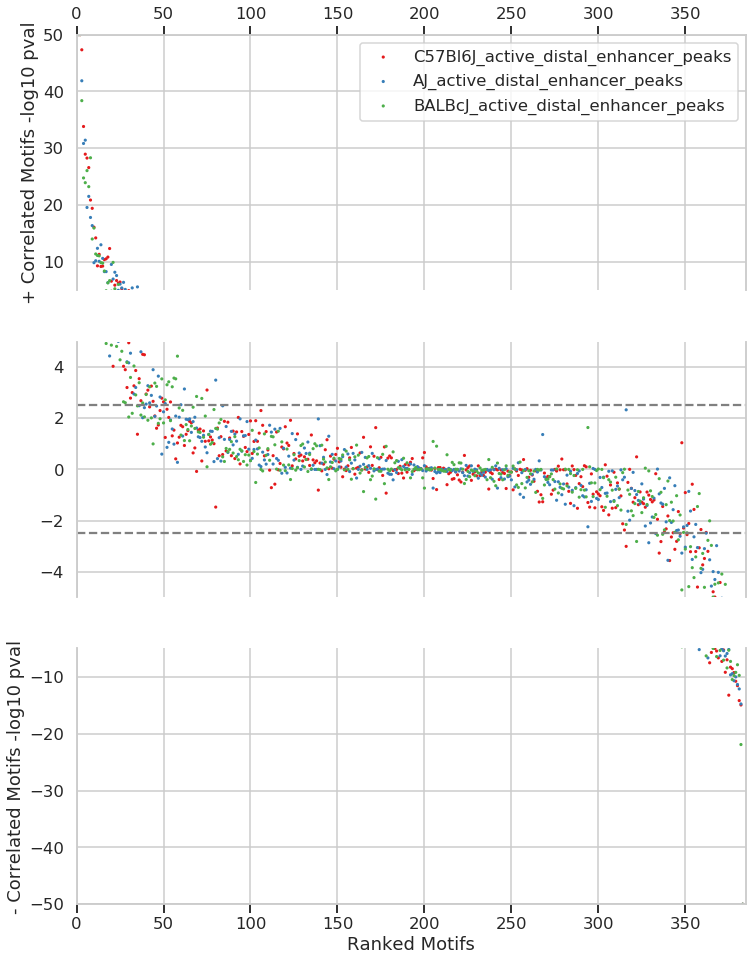

In [15]:
pseudocount = 1e-50 # set ceiling/floor for pvals
n_motifs = 384 # set number of motifs for axis limit
treatments = mean_pval_frame.columns
pval_threshold = 10**-2.5 # position of the dashed lines
treatment_orientedPvals_dict = {}
for treatment in treatments:
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]
    treatment_orientedPvals_dict[treatment] = oriented_pvals

    # create data frame and sort according to mean
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
frame['mean'] = frame.mean(axis=1)
frame.sort_values('mean', ascending = False, inplace=True)
frame.drop('mean', axis=1, inplace=True)

colors = sns.color_palette('Set1', 3)
counter = 0
with sns.axes_style('whitegrid'):
    # define subplots
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize = (12,16))

    for treatment, color in zip(frame.columns.values, colors):
        # color = colors[counter]
        counter += 1
        # top panel
        # bottom panel
        ax1.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
        # middle panel
        ax2.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        # bottom panel
        ax3.scatter(list(range(frame.shape[0])), 
                    frame[treatment], 
                    label = treatment, 
                    c = color,
                    marker = 'o',
                    edgecolor = 'None',
                    s=10)
        
    # scale panels
    plt.xlim(0,n_motifs+1)
    ax1.set_ylim(5, 50)
    ax2.set_ylim(-5, 5)  
    ax3.set_ylim(-50,-5)
    
    # hide the spines between axes
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    ax2.spines['bottom'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop='off')  # don't put tick labels at the top
    
    ax3.xaxis.tick_bottom()
    
    ax2.axhline(xmin=0,xmax=n_motifs+1,y=-np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    ax2.axhline(xmin=0,xmax=n_motifs+1,y=np.log10(pval_threshold+ pseudocount), c='grey', linestyle='--')
    
    ax1.set_ylabel('+ Correlated Motifs -log10 pval')
    ax3.set_ylabel('- Correlated Motifs -log10 pval')
    ax1.legend()
    
    plt.xlabel('Ranked Motifs')


## Pull motif significance values

In [16]:
pseudocount = 1e-50 # pseudocount for calculating logfold change
treatments = mean_pval_frame.columns
# treatment_orientedPvals_dict = {}
for treatment in treatments:
    # retrieve pval and weights cooresponding to treatment
    pvals = mean_pval_frame[treatment]
    weights = mean_weights_frame[treatment]
    
    # calculate logpvals and assign direction according to weight
    oriented_pvals = [np.log10(x[0] +pseudocount) if x[1] < 0 else -np.log10(x[0]+pseudocount) for x in zip(pvals, weights)]

# create data frame
frame = pd.DataFrame(treatment_orientedPvals_dict, index = mean_pval_frame.index.values)
frame.to_csv('./tba_output/tba_pval_frame.txt', sep='\t')

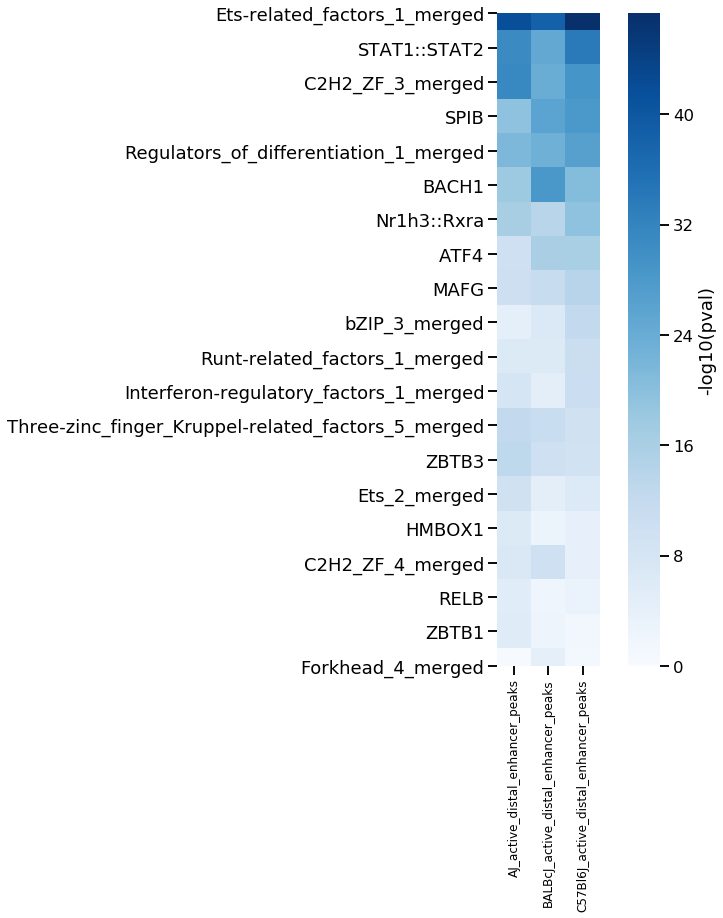

In [24]:
# plot only motifs with log pval > 2 for at least one condition (p<0.01) and positively correlated with active enhancers.
frame = frame.loc[frame.max(axis=1) > 4, np.sort(frame.columns)]
# plot only motifs with absolute log likelihood ratio >=4
filtered_frame = frame[((frame.max(axis=1) - frame.min(axis=1)).abs() >=3)]
# sort frame
filtered_frame = filtered_frame.sort_values('C57Bl6J_active_distal_enhancer_peaks',
                                            ascending=False)
# create heatmap
fig, ax = plt.subplots(figsize=(10,12))
hm = sns.heatmap(
    filtered_frame,
    vmin=0,
    cmap='Blues',
    cbar_kws={'label': '-log10(pval)'},
    square=True,
    ax=ax)
pos = hm.get_position()

hm.set_yticklabels(size=18, labels = [i[:100] for i in filtered_frame.index.values]);
hm.set_xticklabels(size=12, labels = filtered_frame.columns.values, rotation=90);

# draw lines to separate groups
# # plt.plot([.1, .1], [0, 100], linewidth=3, color='r');
# plt.plot([3, 3], [0, 100], linewidth=3, color='r');
# plt.plot([5, 5], [0, 100], linewidth=3, color='orange');
# plt.plot([7.95, 7.95], [0, 100], linewidth=3, color='green');

plt.savefig('./figures/tba_differential_motif_heatmap_all_tfs.pdf',bbox_inches='tight')